# Loading Packages

In [1]:
import Pkg
Pkg.activate("/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/dibs_env")

install_run = false
if install_run
    ENV["PYTHON"]=""
    Pkg.instantiate()
    using Conda
    Conda.add("dustmaps")
#     Pkg.add(["Glob","FITSIO","Serialization", "HDF5", "DelimitedFiles"])
#     Pkg.add(["StatsBase","Distributions","FreqTables", "LsqFit"])
#     Pkg.add(["BinnedStatistics","KrylovKit","ImageTransformations"])
#     Pkg.add(["DataFrames", "ProgressMeter", "Distributed", "BenchmarkTools"])
#     Pkg.add(["Healpix", "SkyCoords", "WCS"])
#     Pkg.add(["LaTeXStrings", "Formatting", "Printf", "PyFormattedStrings"])
#     Pkg.add(["Conda","PyCall","PyPlot
end

#File Handling
using Glob, FITSIO, Serialization, HDF5, DelimitedFiles
# Stats
using StatsBase, LinearAlgebra, Distributions, FreqTables, LsqFit 
using BinnedStatistics, KrylovKit, ImageTransformations
# Computing
using DataFrames, ProgressMeter, Distributed, BenchmarkTools, Random
# Astro
using Healpix, SkyCoords, WCS
# Python Plotting Setup
using PyCall, LaTeXStrings, Formatting, Printf, PyFormattedStrings
import PyPlot; const plt = PyPlot
mpltk=pyimport("mpl_toolkits.axes_grid1")
patches=pyimport("matplotlib.patches")
mplcolors=pyimport("matplotlib.colors")
mplani = pyimport("matplotlib.animation");
cc=pyimport("colorcet")
pyimport("sys")."stdout" = PyTextIO(stdout)
pyimport("sys")."stderr" = PyTextIO(stderr);
py"""
from scipy.stats import binned_statistic_2d
"""

if install_run
    py"""
    from dustmaps.config import config
    config.reset()
    """
end
plt.matplotlib.style.use("dark_background")

  Activating project at `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/dibs_env`


# Preamble

A significant portion of this notebook reads in large datasets (10s-100s GB) in order to construct high-quality priors. This notebook is not meant to be run locally on a personal computer, but on a high memory node on a cluster. The notebook is provided mostly for the code to make the choices in constructing the prior explicit and reproducible.

We construct the priors for the components used in the MADGICS decomposition of the Gaia RVS spectra.

# Meta Information

First, we grab some helpful meta information/summaries of the spectra which have been downloaded from the Gaia archive, stripped, and placed with sorted GaiaID into the gaia_rvs.h5 file.

In [2]:
andrew_dir = "/uufs/chpc.utah.edu/common/home/u6039752/scratch/zenodo/GaiaDIB/GaiaDIB_dat/"
grvs_flux = h5read(andrew_dir*"sources/gaia_rvs.h5","flux");
grvs_dflux = h5read(andrew_dir*"sources/gaia_rvs.h5","dflux");

In [3]:
function SNR_compute(intup)
    signal,error=intup
    msk = findall((.!isnan.(signal)) .& (error.!=0))
    tot = 0
    for ind in msk
        tot += signal[ind]/error[ind]
    end
    return tot/length(msk)
end

SNR_compute (generic function with 1 method)

In [4]:
SNR_lst = @showprogress map(SNR_compute,zip(eachcol(grvs_flux),eachcol(grvs_dflux)));

Progress: 100%|█████████████████████████████████████████| Time: 0:00:2139m


In [5]:
# h5write("../priors/SNR_lst.h5","SNR_lst",SNR_lst)

This is a measure of the stellar SNR by looking at the average signal over the average reported uncertainty per pixel over the spectrum.

In [5]:
nanmat = isnan.(grvs_flux);
nansum = dropdims(sum(nanmat,dims=2),dims=2);

star_msk = nansum[:].<100;
nansum = dropdims(sum(nanmat[star_msk,:],dims=1),dims=1).==0;

In [6]:
mean_grvs = dropdims(mean(grvs_flux[star_msk,:],dims=1),dims=1);
# h5write("../priors/mean_rvs.h5","mean",mean_grvs)

The mean of the spectrum gives some idea of the continuum normalization (and variations in the continuum normalization) imposed upstream.

In [7]:
# serialize("../priors/star_mask.jdat",[star_msk, nansum])

We save the set of pixels that will be our common data space (star_msk) and a list of spectra that have full coverage across that range.

In [8]:
nsamp = size(grvs_dflux,2)
sig_noise = zeros(nsamp)
@showprogress for i=1:nsamp
    sig_noise[i] = median(grvs_dflux[:,i][star_msk])
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:46m


In [9]:
# serialize("../priors/sig_noise.jdl",sig_noise);

This just gives an average (median) measure of the per-pixel uncertainty in a given spectrum. This is useful when computing the ground truth SNR of an injected DIB later.

In [10]:
star_msk, nansum = deserialize(andrew_dir*"priors/star_mask.jdat");
SNR_lst = h5read(andrew_dir*"priors/SNR_lst.h5","SNR_lst");
nfeat = count(star_msk)
cwave = 8623.14;

# Stellar Prior

Now we build the stellar prior from high quality low dust spectra of stars.

In [11]:
#These are all a permutation off of my sorted ordering of the Gaia spectra
f = FITS(andrew_dir*"gaia_archive_results/RVS_astro-result.fits.gz")
astro_source_id = read(f[2],"source_id")
flags_gspspec = read(f[2],"flags_gspspec");
close(f)

f = FITS(andrew_dir*"gaia_archive_results/RVS_source-result.fits.gz")
RVS_source_id = read(f[2],"source_id")
ra = read(f[2],"ra")
dec = read(f[2],"dec")
close(f)

ps = sortperm(RVS_source_id);

In [12]:
grvs = h5open(andrew_dir*"sources/gaia_rvs.h5");
grvs_id = read(grvs["SOURCE_ID"]);
glon = read(grvs["GLON"]);
glat = read(grvs["GLAT"]);

py"""
from astropy.coordinates import SkyCoord
import astropy.units as units
from dustmaps.sfd import SFDWebQuery
sfd = SFDWebQuery()
l = $glon
b = $glat
coords = SkyCoord(l*units.deg, b*units.deg, frame='galactic')
sfd_reddening = sfd(coords)
"""

sfd_red = 1 .* py"sfd_reddening";

query SFD extinction map to find low reddening stars (those with little dust)

In [13]:
function mask_gspspec_flag(flagstring)
    good = true
    if length(flagstring)==41
        for i=1:13
            good &= (flagstring[i].=='0')
        end
        return good
    else
        good = false
        return good
    end
end

mask_gspspec_flag (generic function with 1 method)

In [14]:
msk_flags_gspspec = mask_gspspec_flag.(flags_gspspec[ps]);

In [15]:
xmin0 = 8460
xmax0 = 8700
wavex = xmin0:0.1:xmax0
cgrid = 8623.54;

wavex is just the wavelength axis of the RVS spectra

## Clean Stars

In [16]:
msk_inter = nansum .& (SNR_lst.>70) .& (sfd_red.<0.05) .& msk_flags_gspspec
count(msk_inter), count(msk_inter)/length(msk_inter)

(39657, 0.039671083234548266)

In [17]:
grvs_flux = h5read(andrew_dir*"sources/gaia_rvs.h5","flux");

In [18]:
weights

weights (generic function with 3 methods)

In [19]:
size(grvs_flux)

(2401, 999645)

In [20]:
size(msk_inter)

(999645,)

In [21]:
weights2 = clamp.(SNR_lst[msk_inter],70,300);

sv_grv = reshape(weights2,1,:).*(grvs_flux[:,msk_inter].-0.95);

maxw = maximum(wavex[star_msk])
minw = minimum(wavex[star_msk]);
nsamp = size(sv_grv,2)

39657

we use SNR based weights, limiting the high SNR stars from dominating the training by clamping weights at 300. 

In [22]:
norm_weights = weights2'*weights2
dat = sv_grv[star_msk,:];
Cstar = dat*dat'
Cstar./=norm_weights
println(maximum(Cstar.-Cstar'))
isposdef(Cstar)

0.0


true

That is it! Just build the covariance matrix with X X^T (normalizing to handle the weights)

In [23]:
# Cstar .+= (1e-1)*ones(size(Cstar));
isposdef(Cstar)

true

In [24]:
Cstarinv = inv(cholesky(Cstar))
isposdef(Cstarinv)

true

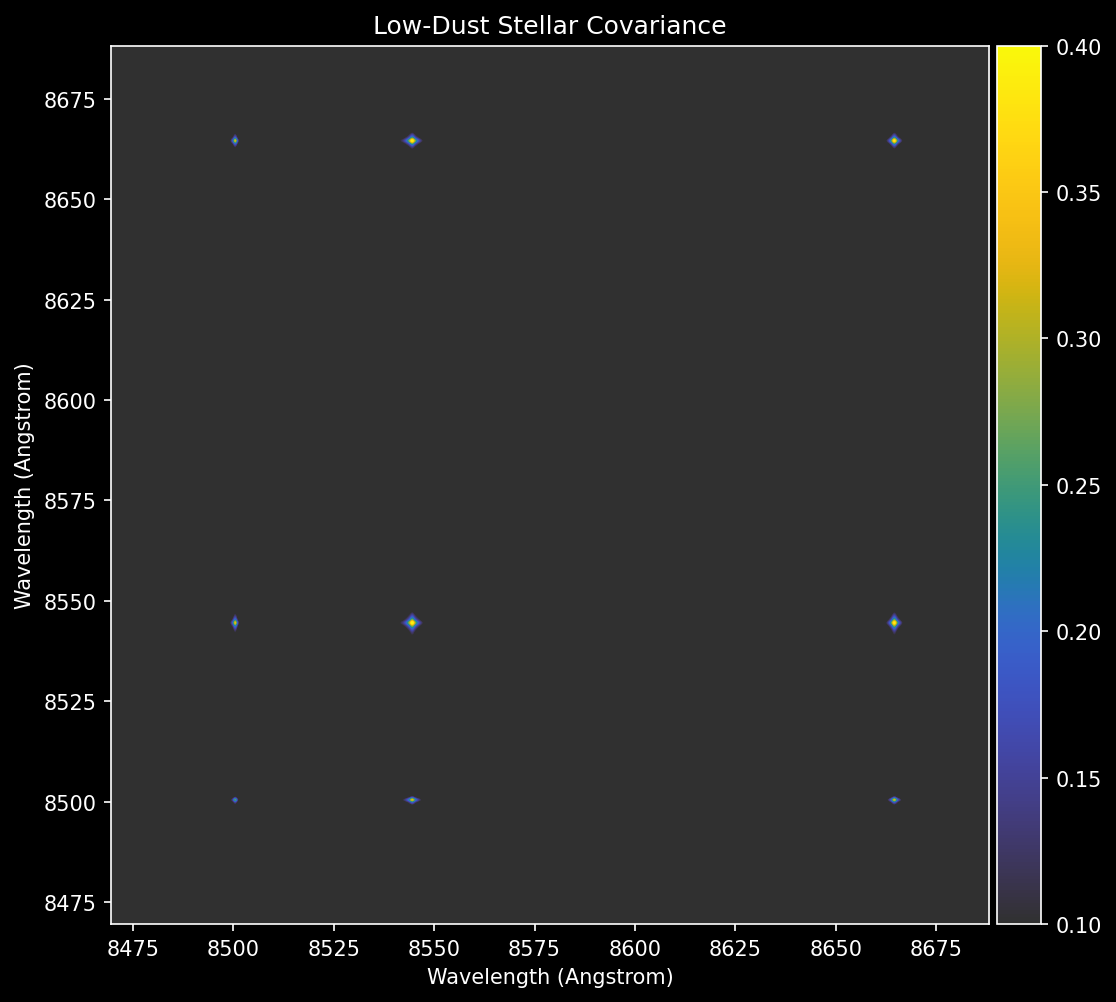

PyObject Text(0.5, 1.0, 'Low-Dust Stellar Covariance')

In [26]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(1,1,1)
img = ax.imshow(Cstar,
    extent=(minw,maxw,minw,maxw),
    cmap="cet_gouldian",
    vmin=0.1,
    vmax=0.4,
    origin="lower"
)

divider = mpltk.make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax, orientation="vertical")

ax.set_xlabel("Wavelength (Angstrom)")
ax.set_ylabel("Wavelength (Angstrom)")
ax.set_title("Low-Dust Stellar Covariance")

Here we visualize the stellar covariance matrix which is acting as our prior for the stellar component in the MADGICS decomposition.

In [25]:
SF = svd(Cstar);
SF.S

2189-element Vector{Float64}:
 21.859696988395303
  0.373186272187329
  0.0341035532551088
  0.02200633135262326
  0.012627552310233367
  0.005976898191696082
  0.003062704970305474
  0.002509840699296654
  0.0012160889388915068
  0.0010112608266097769
  0.0008099837678850267
  0.0006375502621679836
  0.000606004031775747
  ⋮
  2.8285901419865755e-7
  2.772704446320956e-7
  2.735038958483426e-7
  2.7315349112802394e-7
  2.6998071898932823e-7
  2.621819976563247e-7
  2.596847892365253e-7
  2.590948969908823e-7
  2.498348298915304e-7
  2.3205022178673847e-7
  2.3109713383430162e-7
  2.0967167727784678e-7

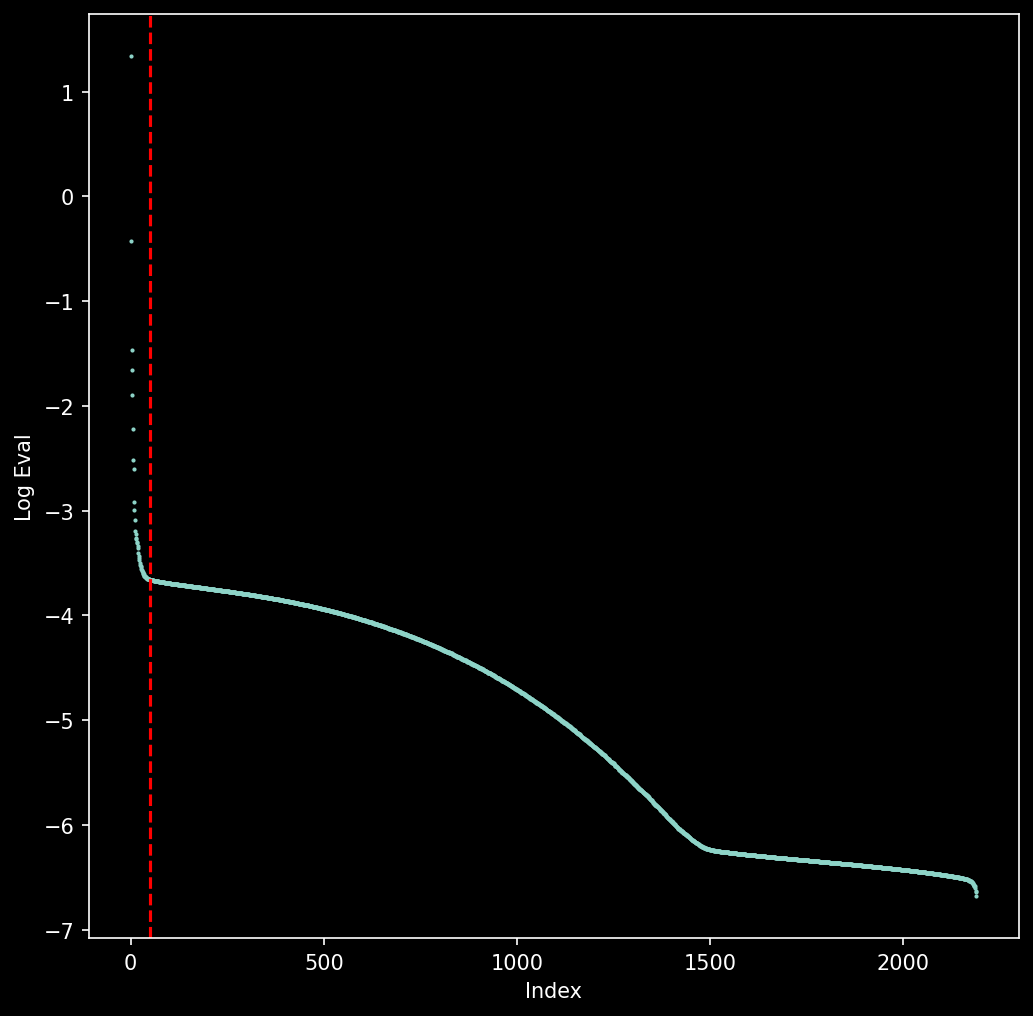

PyObject <matplotlib.lines.Line2D object at 0x153f0c292aa0>

In [96]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(1,1,1)
ax.scatter(1:length(SF.S),log10.(SF.S),s=1)
ax.set_xlabel("Index")
ax.set_ylabel("Log Eval")
ax.axvline(50,color="red",linestyle="--")

This shows that the stellar covariance matrix eigenspectrum falls off very quickly and is at the level of noise at the value of 50 eigenvectors that we are keeping for our representation.

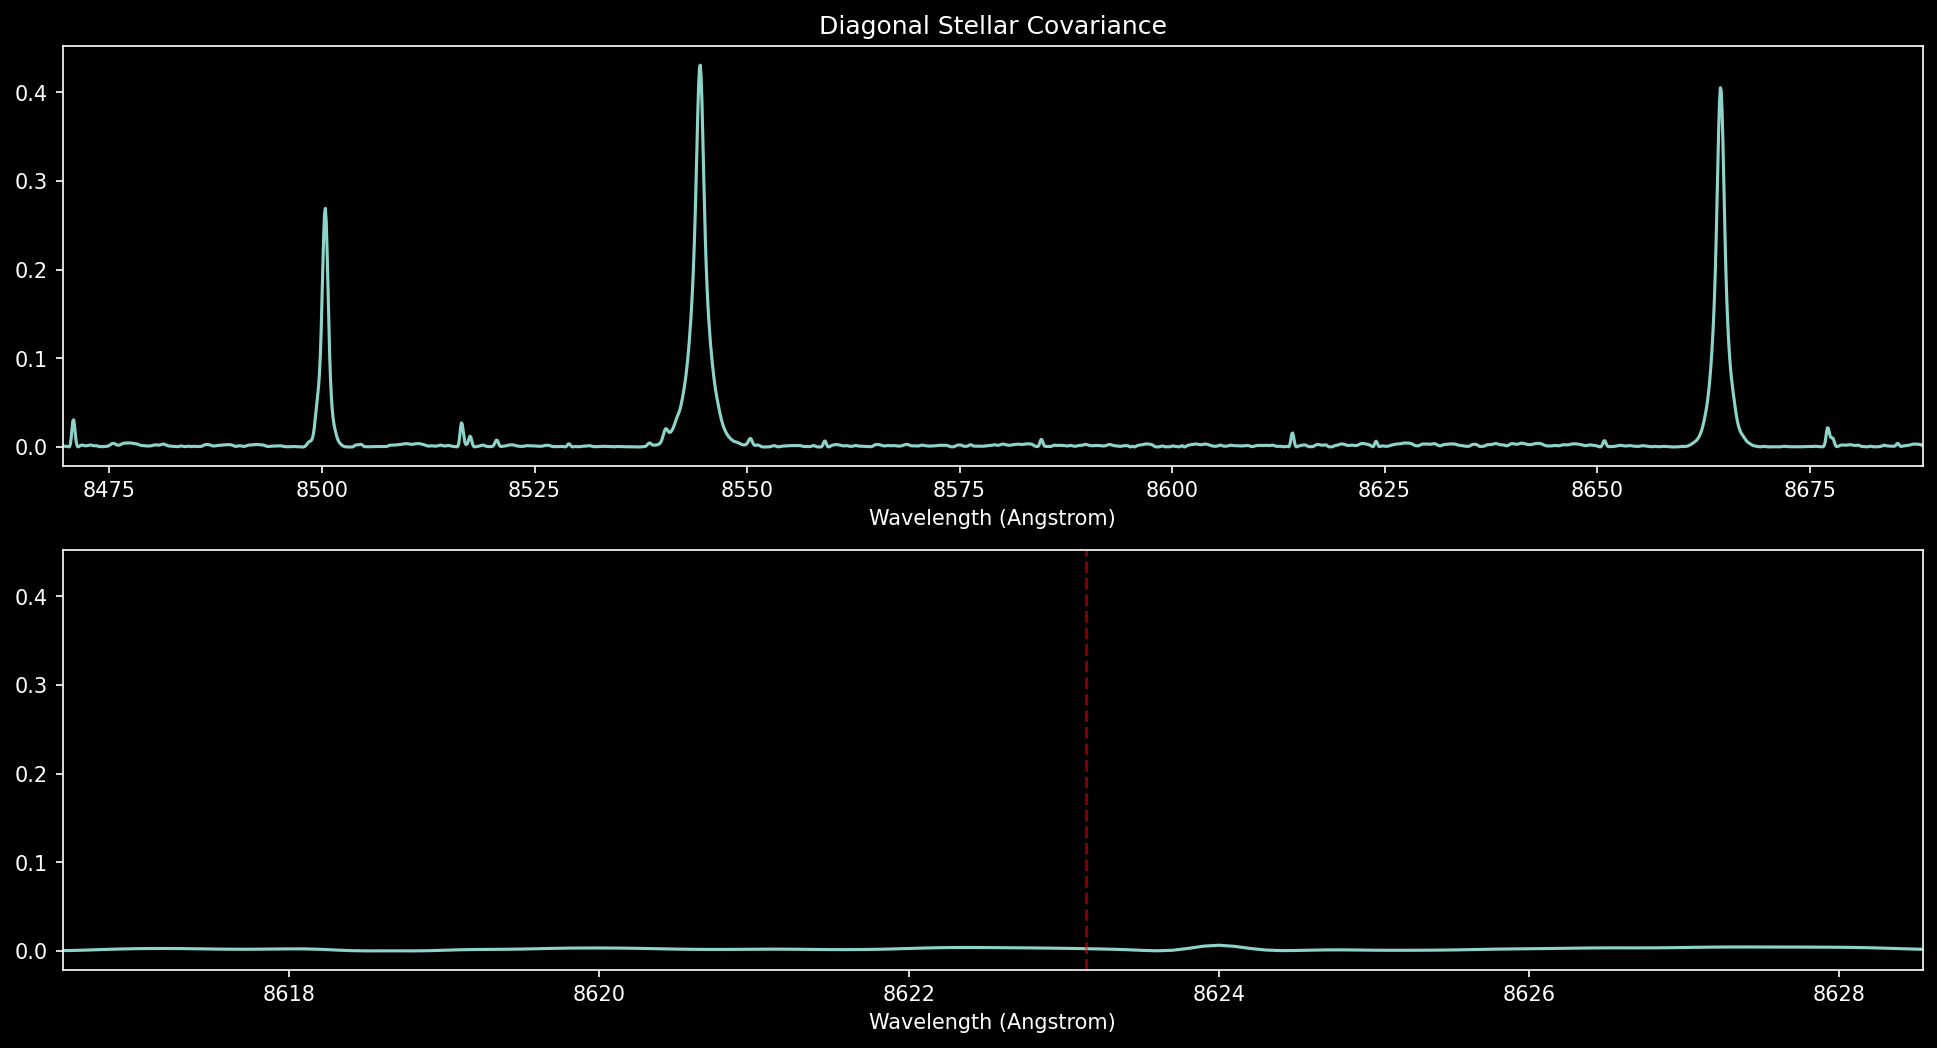

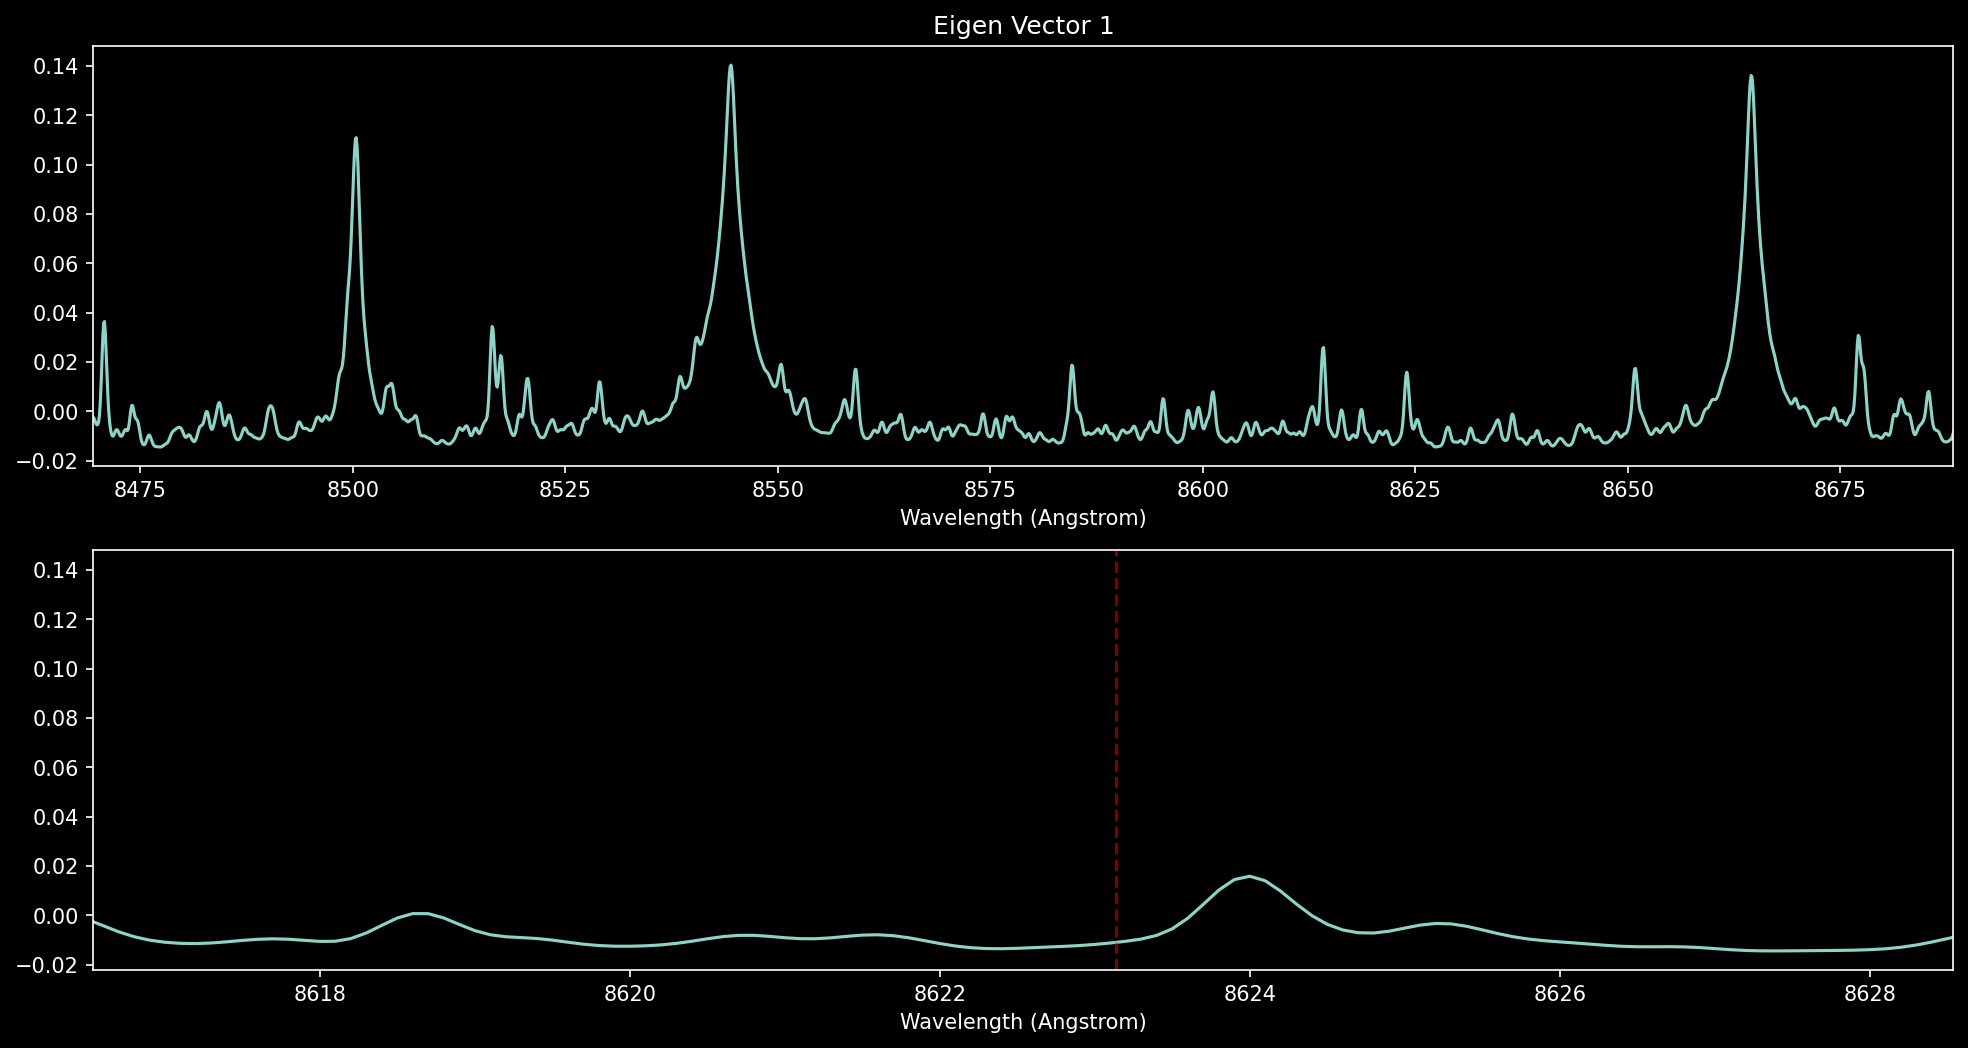

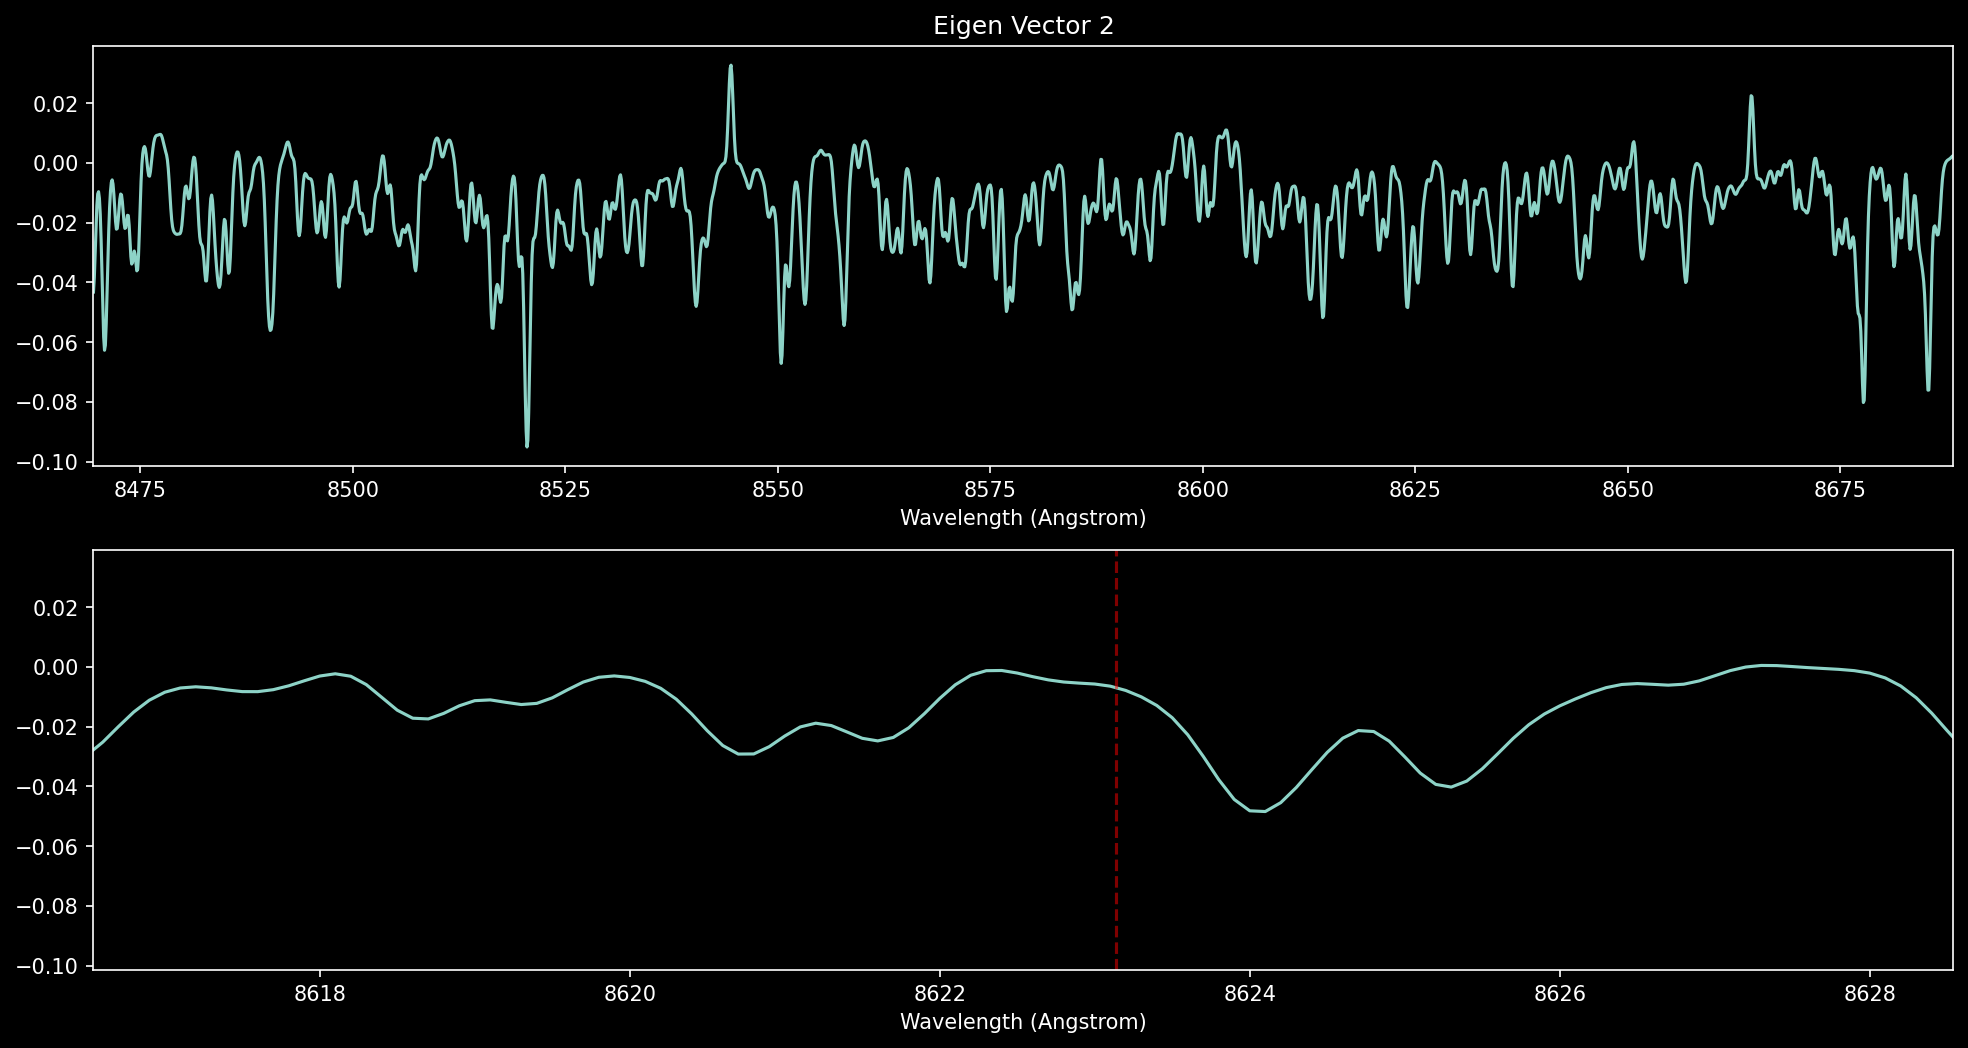

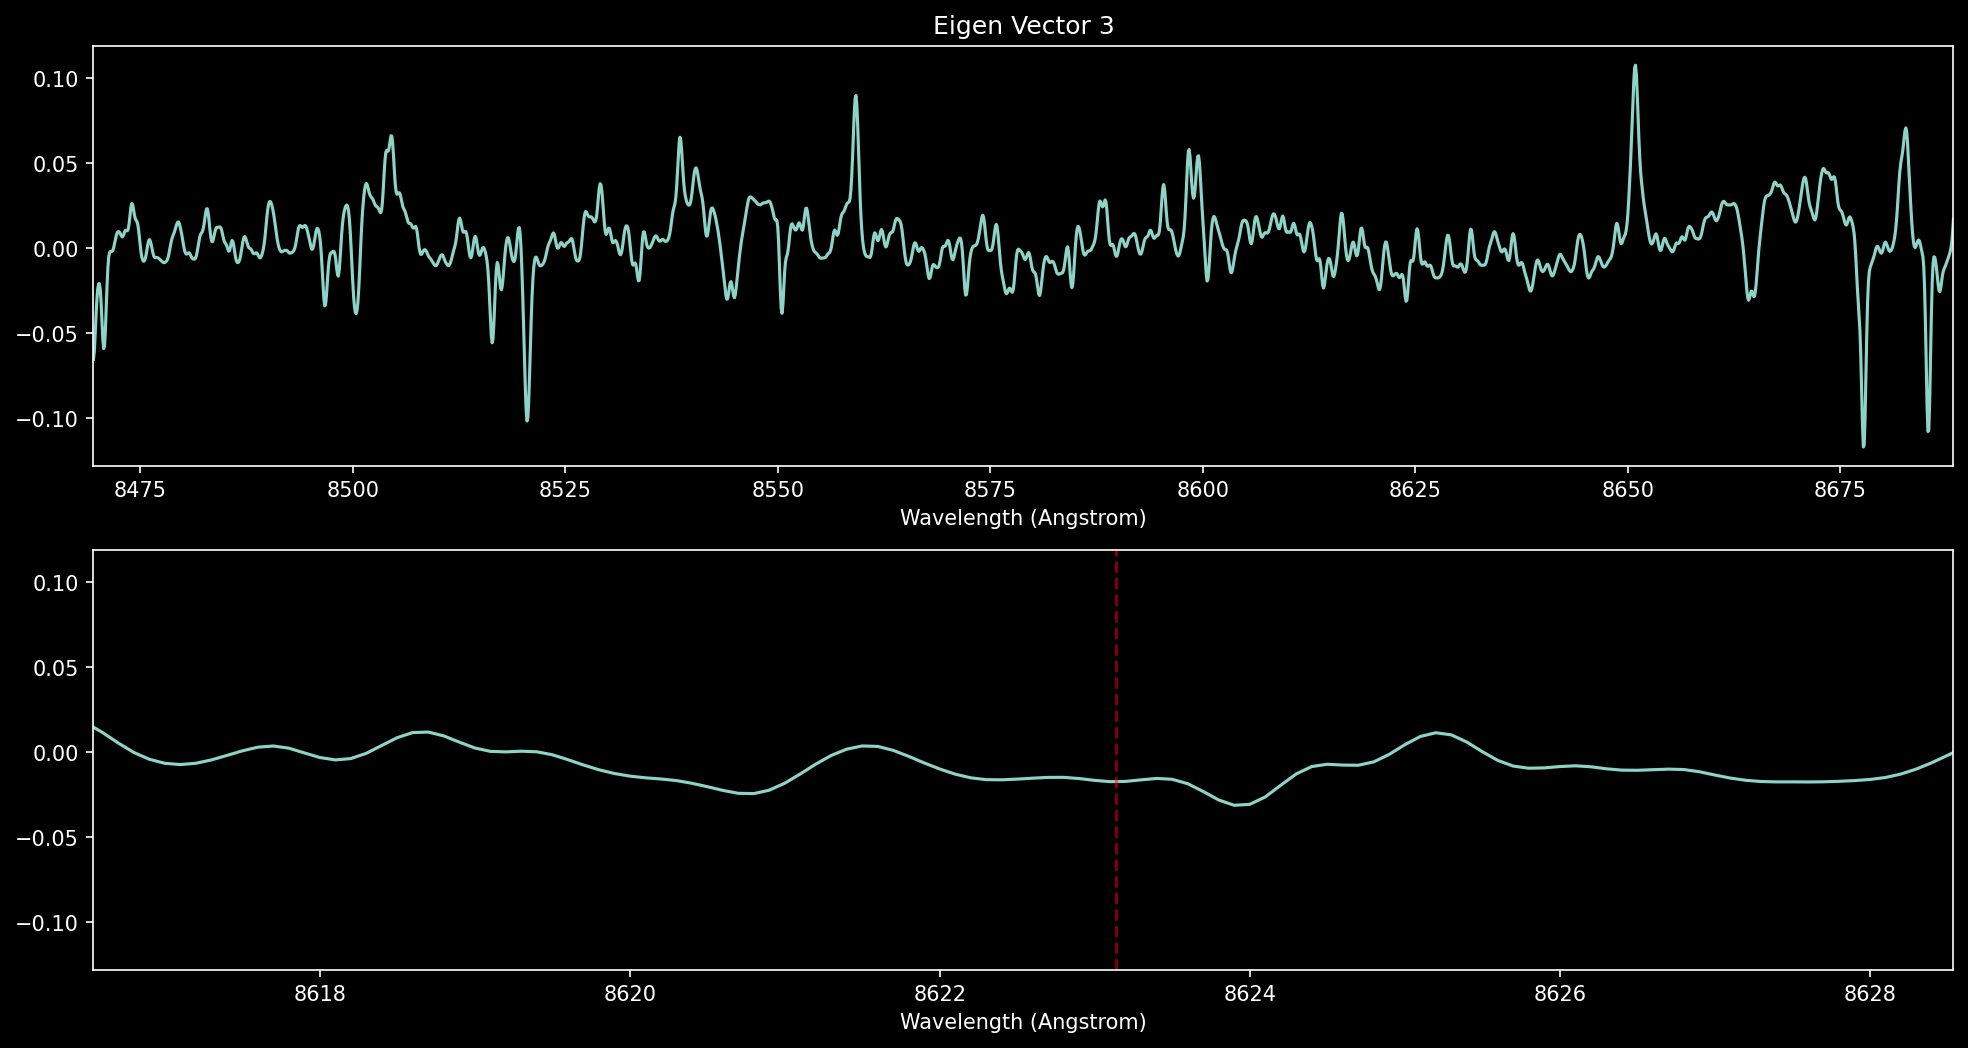

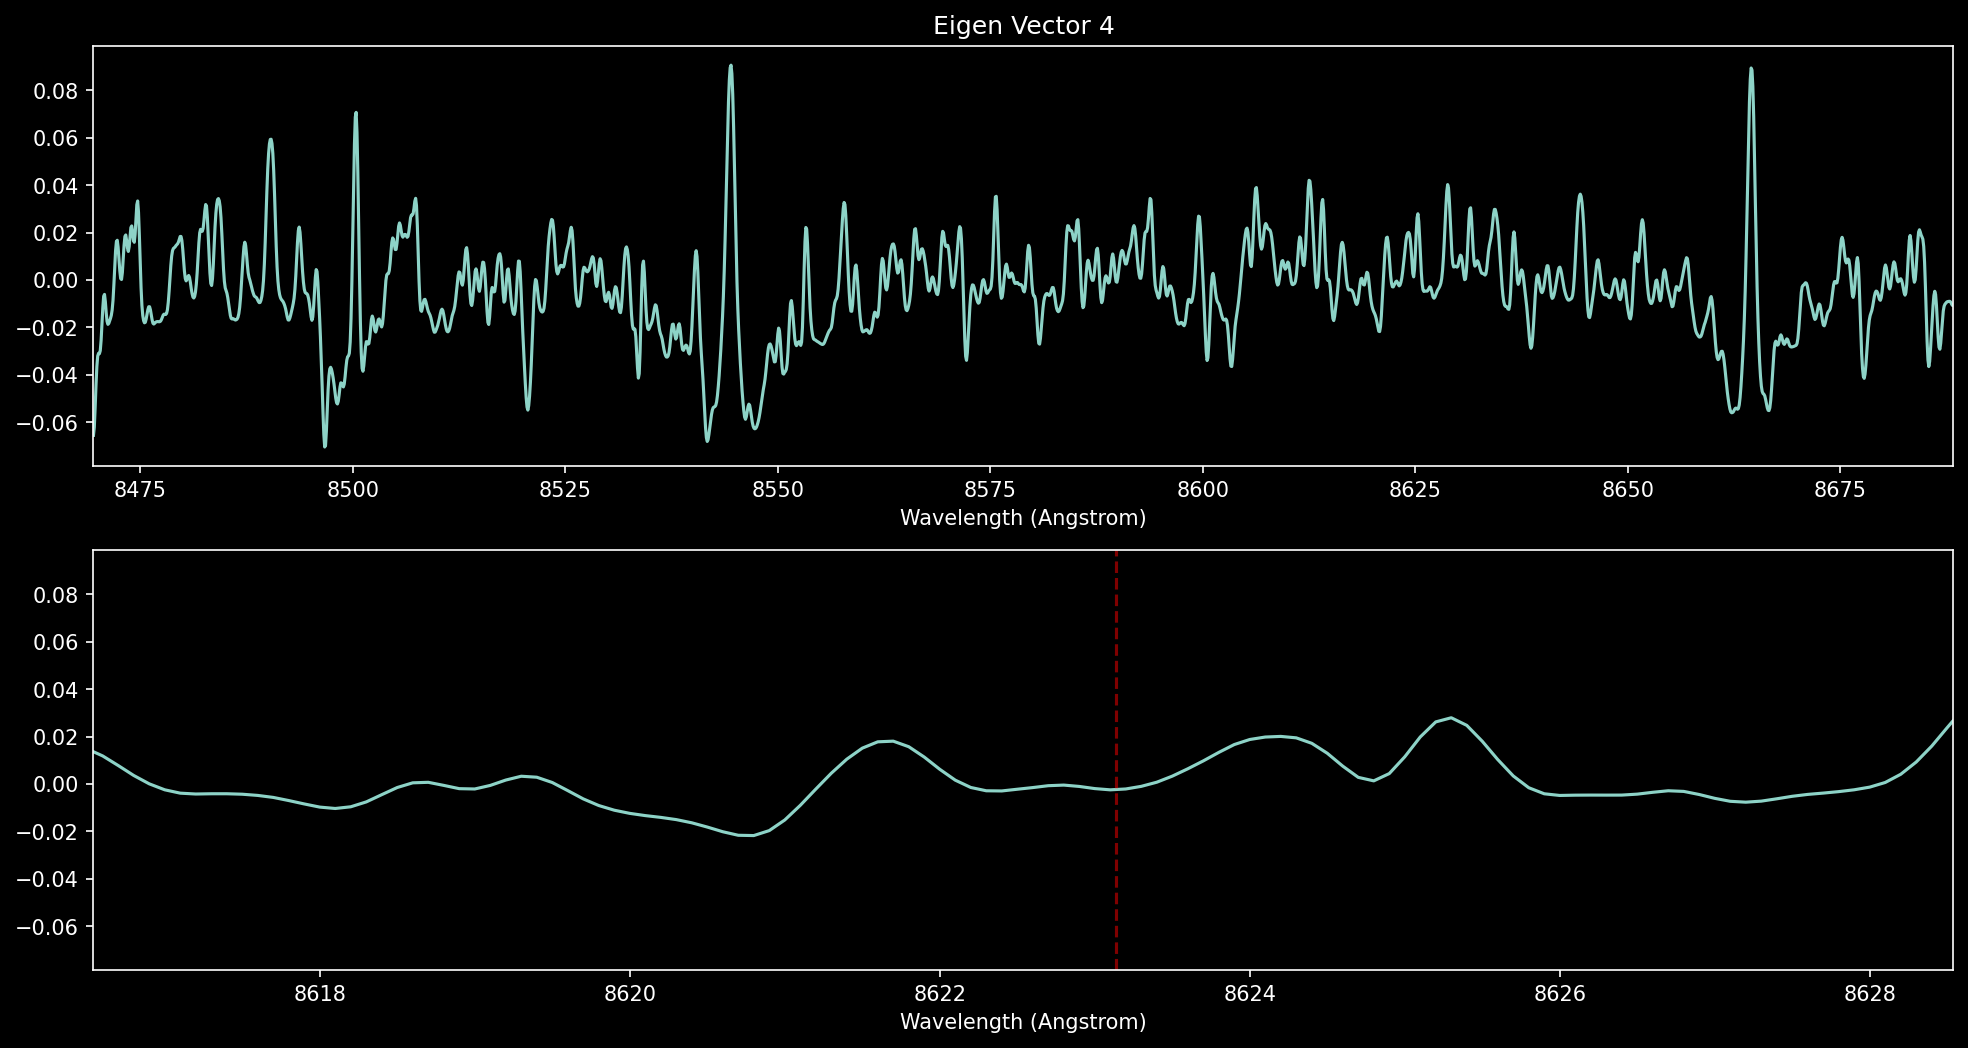

In [97]:
fig = plt.figure(figsize=(16,8),dpi=150)
ax = fig.add_subplot(2,1,1)
ax.plot(wavex[star_msk],diag(Cstar))
ax.set_xlim(minw,maxw)
ax.set_xlabel("Wavelength (Angstrom)")
ax.set_title("Diagonal Stellar Covariance")

ax = fig.add_subplot(2,1,2)
ax.plot(wavex[star_msk],diag(Cstar))
ax.set_xlim(cgrid-7,cgrid+5)

ax.axvline(cwave,color="red",linestyle="--",alpha=0.5)

ax.set_xlabel("Wavelength (Angstrom)")

for indx = 1:4
    
    fig = plt.figure(figsize=(16,8),dpi=150)
    ax = fig.add_subplot(2,1,1)
    ax.plot(wavex[star_msk],SF.U[:,indx])
    ax.set_xlim(minw,maxw)
    ax.set_xlabel("Wavelength (Angstrom)")
    ax.set_title("Eigen Vector $indx")

    ax = fig.add_subplot(2,1,2)
    ax.plot(wavex[star_msk],SF.U[:,indx])
    ax.set_xlim(cgrid-7,cgrid+5)

    ax.axvline(cwave,color="red",linestyle="--",alpha=0.5)
    
    ax.set_xlabel("Wavelength (Angstrom)")
end

Plotting just the first few eigenvectors of the covariance matrix for inspection. No features that look like the DIB are clearly visible in the components.

In [36]:
nsub = 50
λ, V, info = eigsolve(Symmetric(Cstar),nsub,krylovdim=2*nsub,issymmetric=true,:LR);
size(λ), size(V)

((52,), (52,))

In [37]:
λ

52-element Vector{Float64}:
 21.859696988395264
  0.373186272187329
  0.03410355325510877
  0.022006331352623337
  0.012627552310233318
  0.005976898191696078
  0.003062704970305583
  0.002509840699296845
  0.0012160889388915012
  0.0010112608266097311
  0.0008099837678852302
  0.0006375502621678711
  0.0006060040317760966
  ⋮
  0.00022890395400406506
  0.00022719354108057815
  0.00022525058204114393
  0.00022450331337719407
  0.0002236922532090786
  0.0002230252353538151
  0.00022159391368173863
  0.00022134152579558804
  0.00022067962086387883
  0.00022033637691061983
  0.00022019477663319935
  0.0002194287636097686

In [39]:
λ[50] = 200

200

In [38]:
size(V)

(52,)

In [40]:
V[50] = ones(2189);

In [30]:
size(V)

(52,)

In [35]:
V[50,:]

1-element Vector{Vector{Float64}}:
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [52]:
sum(λ[2:end])

1.4690980232100739

Representing the covariance matrix using a 50-dimensional subspace. This significantly speeds up the MADGICS computation.

In [41]:
fname = "modified_prior_200.h5"
h5write(fname,"Cstar",Cstar)
h5write(fname,"Cstarinv",Cstarinv)
h5write(fname,"Vmat",hcat(V[1:nsub]...)*Diagonal(sqrt.(λ[1:nsub])))
h5write(fname,"λv",λ[1:nsub])
h5write(fname,"λinv",1 ./λ[1:nsub]);
h5write(fname,"msk",convert.(Int,msk_inter));
h5write(fname,"train_source_id",grvs_id[msk_inter]); 

## Dirtier Stars

we loosen the requirement on how much dust can be along the line of sight for stars in our training sample for the stellar covariance

In [86]:
msk_dirt = nansum .& (SNR_lst.>70) .& (sfd_red.<0.1) .& msk_flags_gspspec
count(msk_dirt), count(msk_dirt)/length(msk_dirt)

(71266, 0.07129130841448714)

In [87]:
weights = clamp.(SNR_lst[msk_dirt],70,300);
sv_grv = reshape(weights,1,:).*(grvs_flux[:,msk_dirt].-0.95);

maxw = maximum(wavex[star_msk])
minw = minimum(wavex[star_msk]);
nsamp = size(sv_grv,2)

71266

In [88]:
norm_weights = weights'*weights
dat = sv_grv[star_msk,:];
Cstar = dat*dat'
Cstar./=norm_weights
println(maximum(Cstar.-Cstar'))
isposdef(Cstar)

0.0


true

In [89]:
Cstar .+= (1e-1)*ones(size(Cstar));
isposdef(Cstar)

true

In [90]:
Cstarinv = inv(cholesky(Cstar))
isposdef(Cstarinv)

true

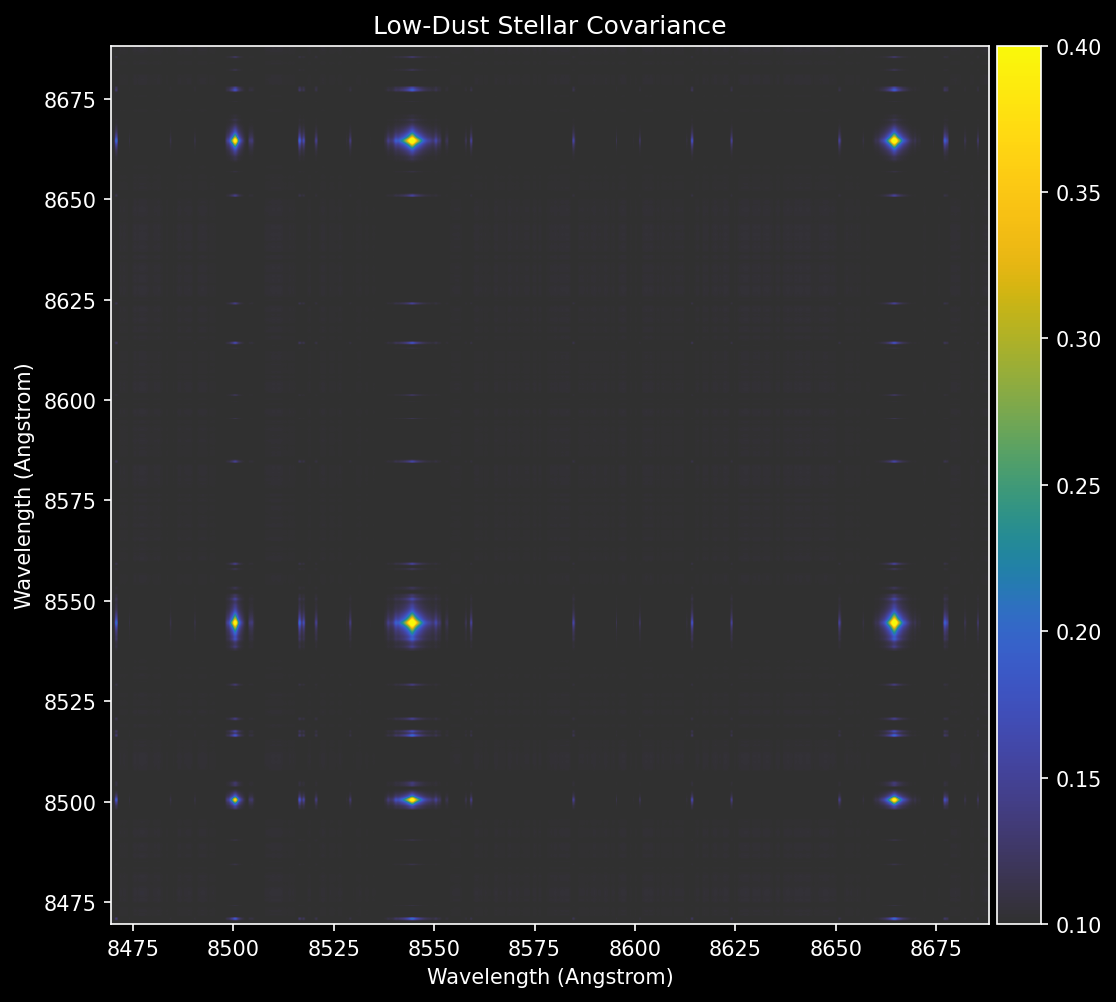

PyObject Text(0.5, 1.0, 'Low-Dust Stellar Covariance')

In [91]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(1,1,1)
img = ax.imshow(Cstar,
    extent=(minw,maxw,minw,maxw),
    cmap="cet_gouldian",
    vmin=0.1,
    vmax=0.4,
    origin="lower"
)

divider = mpltk.make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax, orientation="vertical")

ax.set_xlabel("Wavelength (Angstrom)")
ax.set_ylabel("Wavelength (Angstrom)")
ax.set_title("Low-Dust Stellar Covariance")

In [92]:
SF = svd(Cstar);
SF.S

2189-element Vector{Float64}:
 219.14381685275762
  22.77624737762407
   0.1799997564098154
   0.035259774185280826
   0.020833471283250738
   0.011325724266175688
   0.0030384460670975803
   0.002500711874361125
   0.0017077633395287857
   0.001393901992100508
   0.0009282833575355065
   0.0008579127959427266
   0.0006885521252513698
   ⋮
   3.0115421761861883e-7
   2.9616332334828217e-7
   2.921673213929073e-7
   2.8810062057718055e-7
   2.85719617923399e-7
   2.766144110967745e-7
   2.759654924401275e-7
   2.7518915531334006e-7
   2.635506593474914e-7
   2.4374639287665346e-7
   2.43407221104019e-7
   2.178303092049734e-7

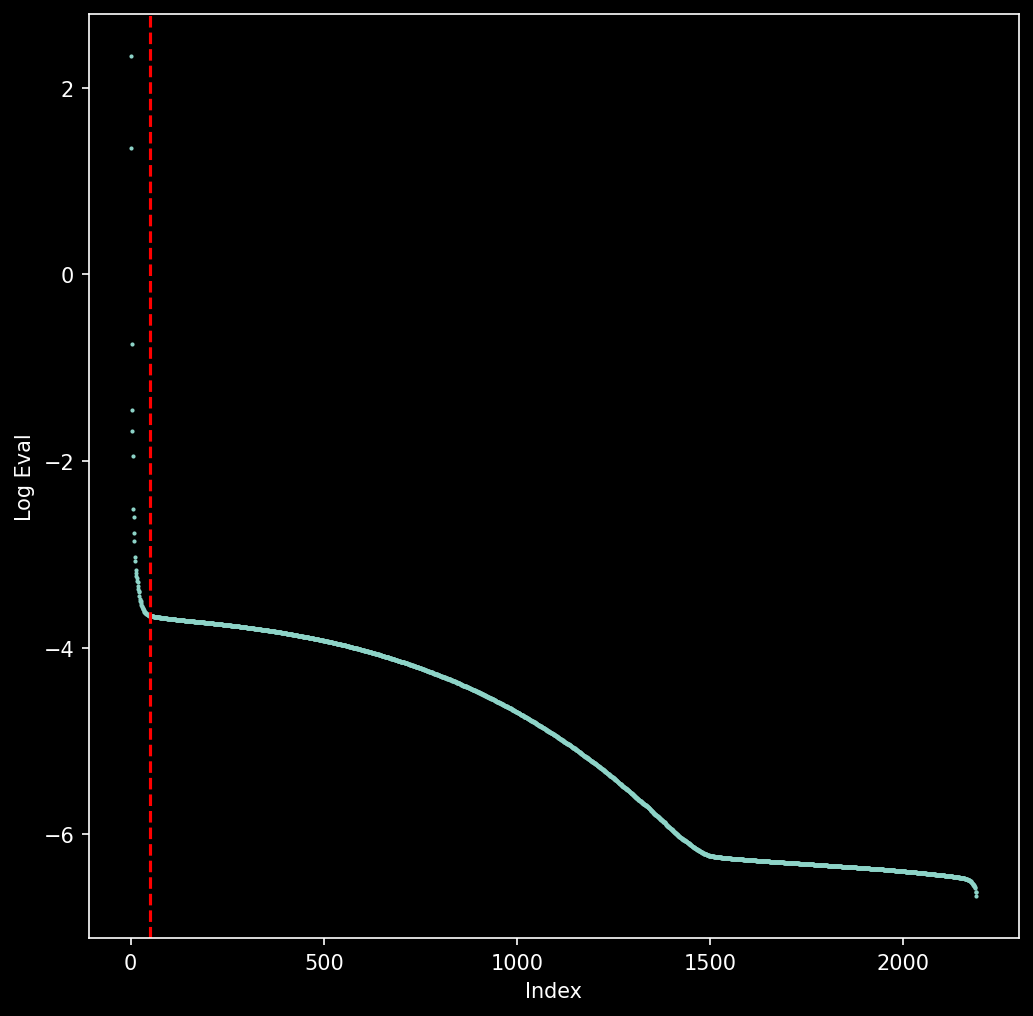

PyObject <matplotlib.lines.Line2D object at 0x1464be87a610>

In [93]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(1,1,1)
ax.scatter(1:length(SF.S),log10.(SF.S),s=1)
ax.set_xlabel("Index")
ax.set_ylabel("Log Eval")
ax.axvline(50,color="red",linestyle="--")

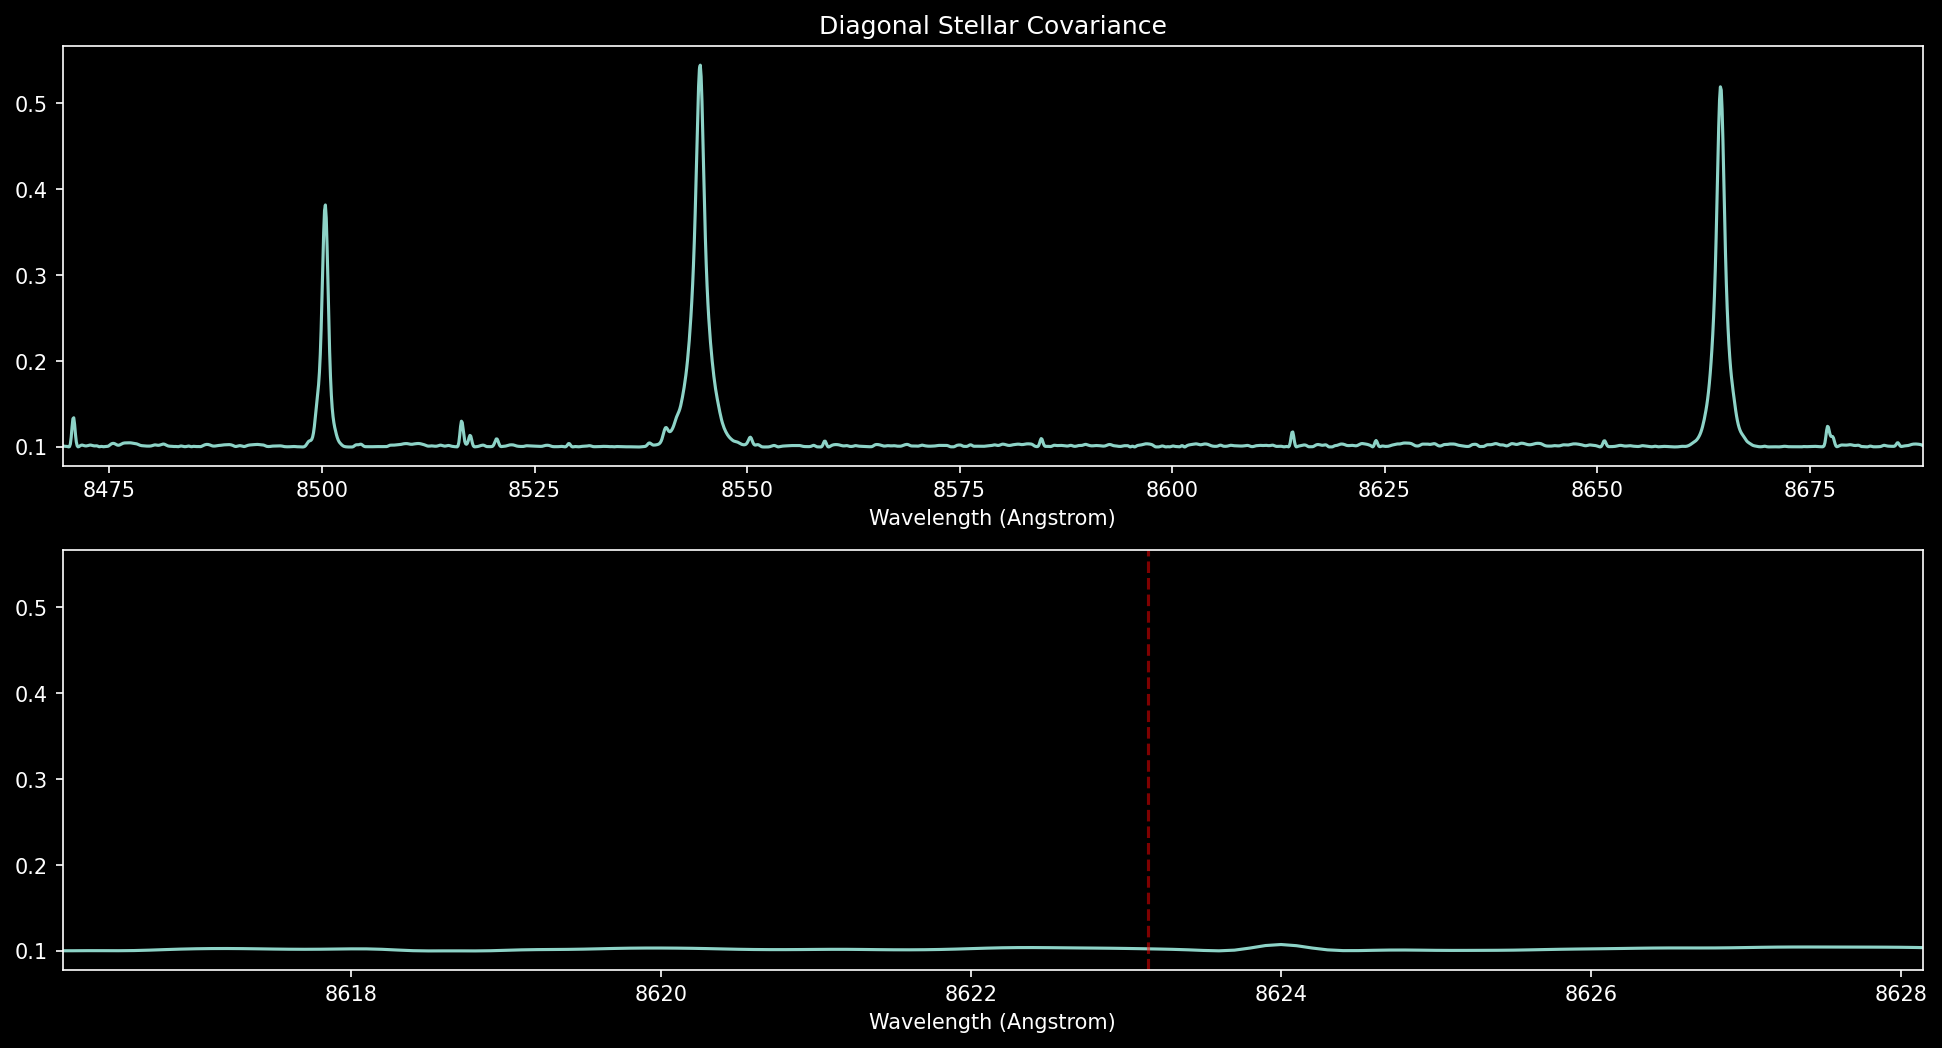

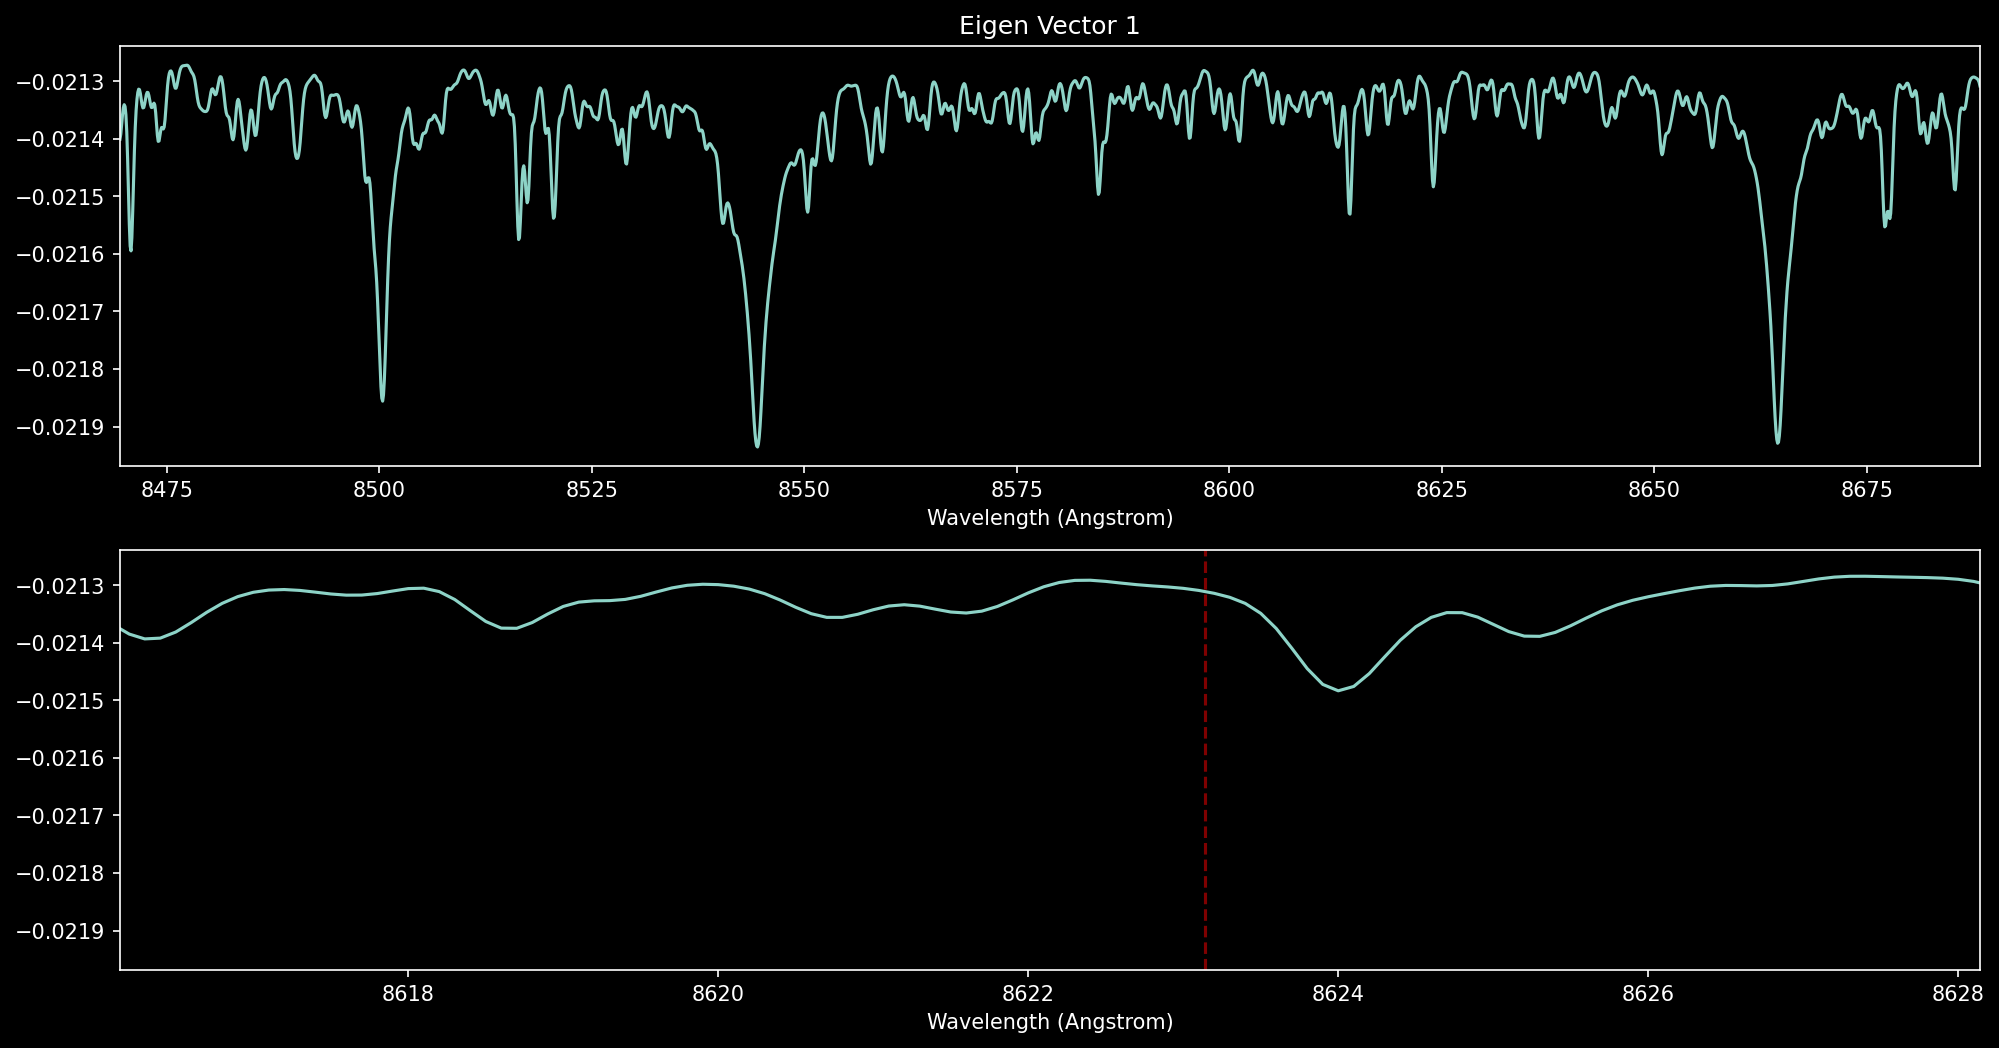

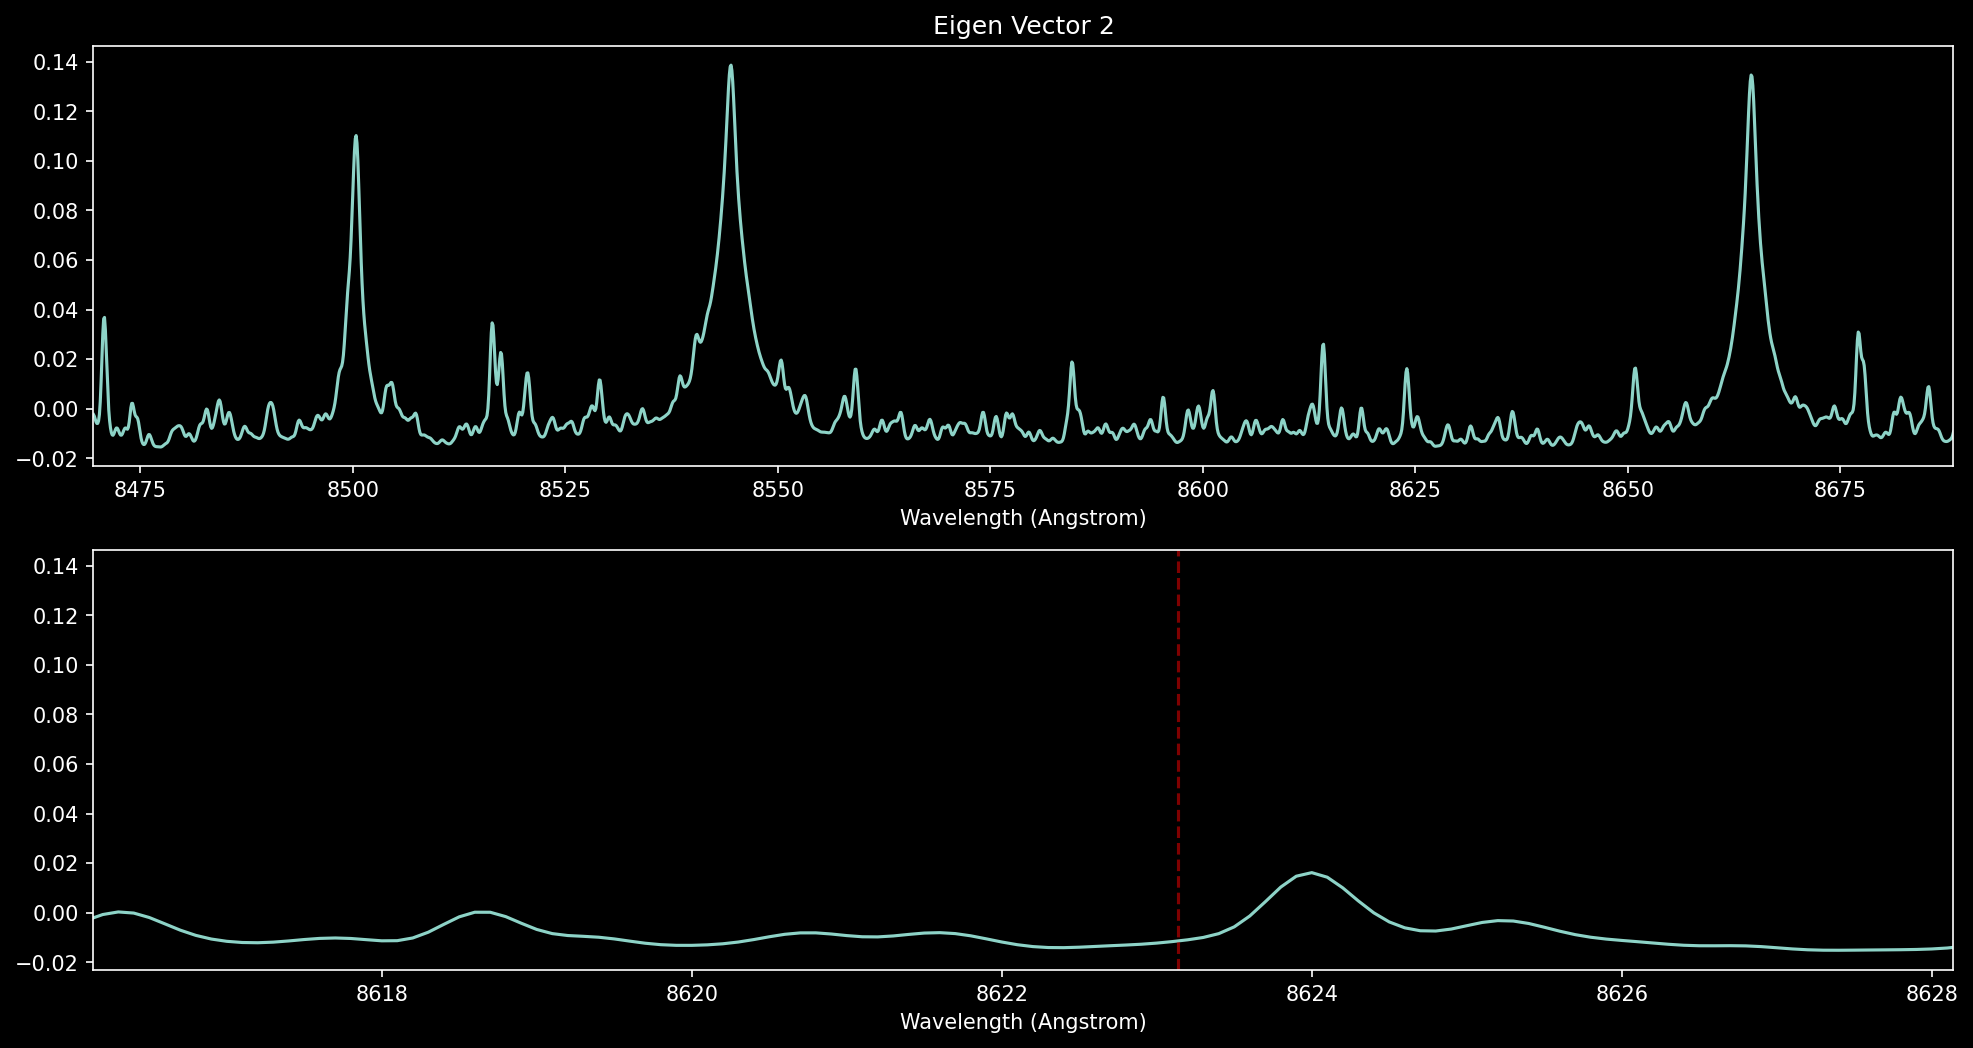

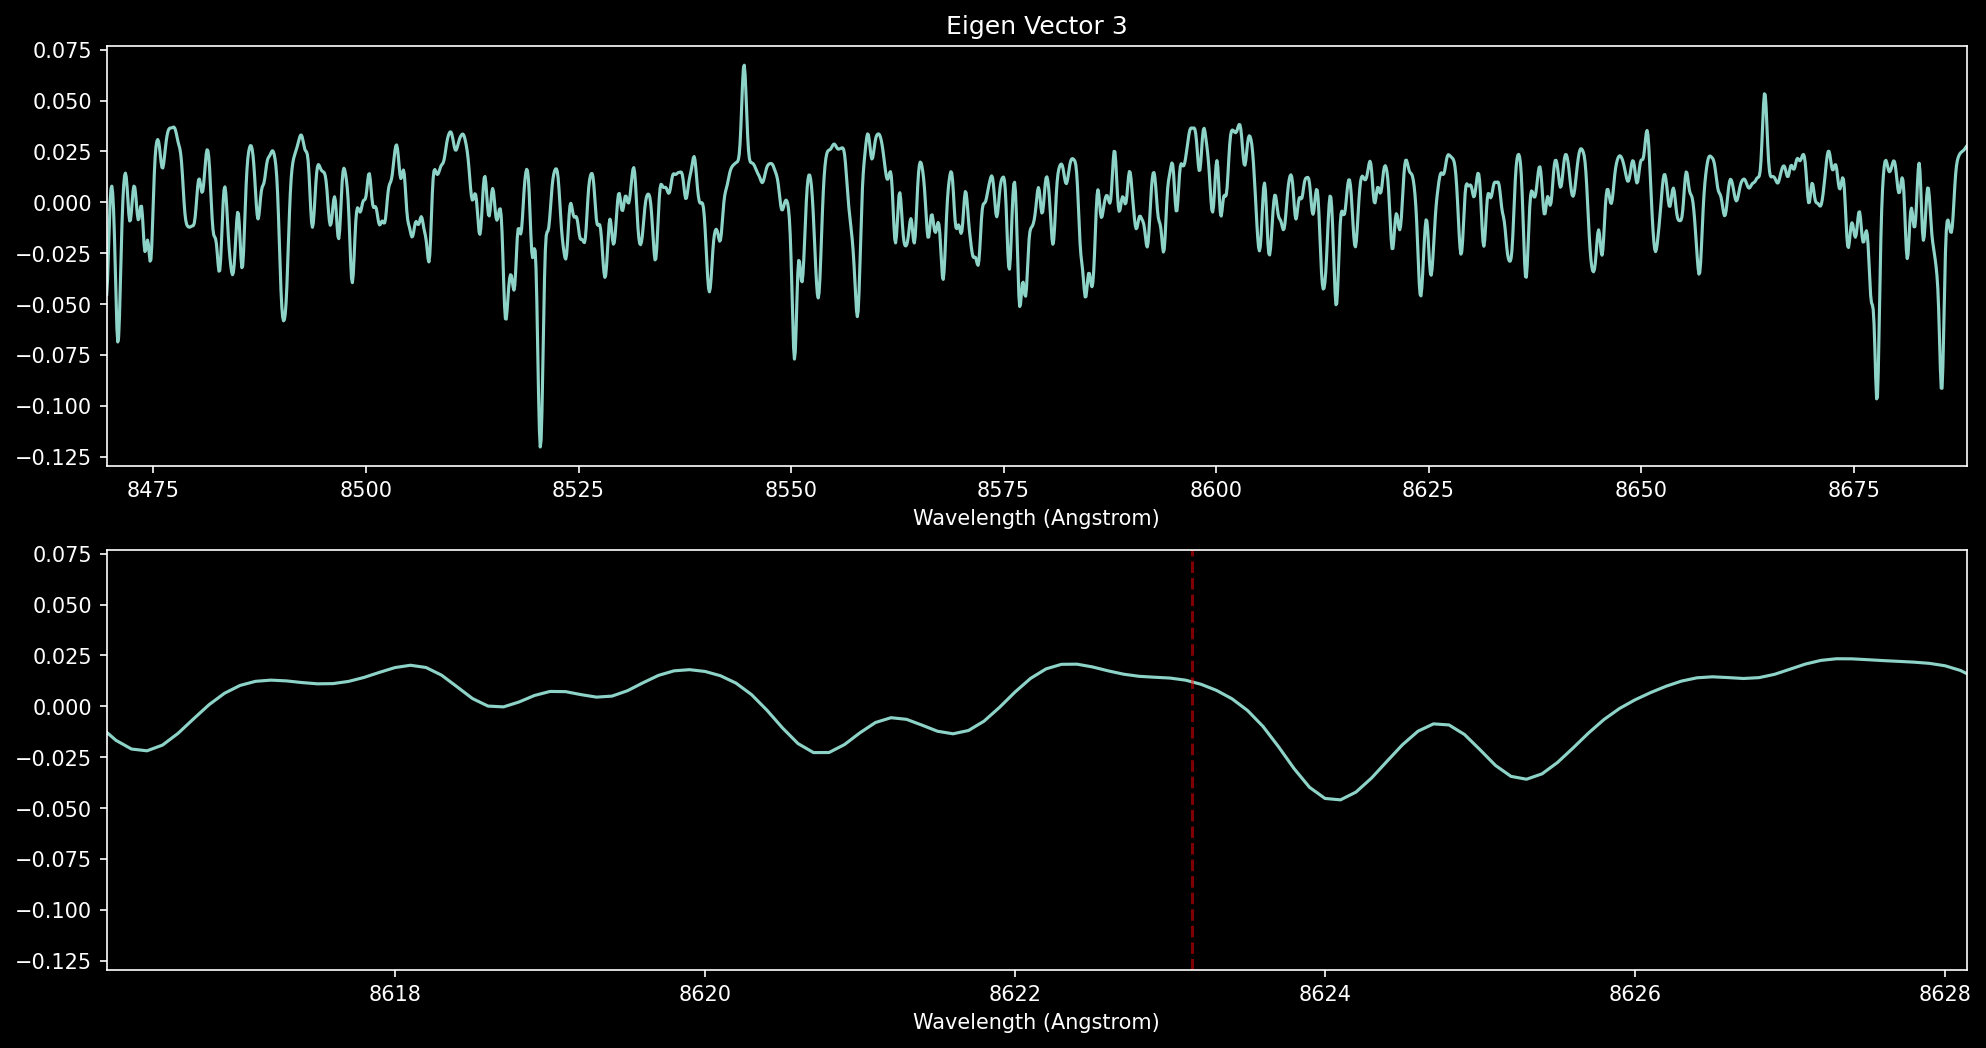

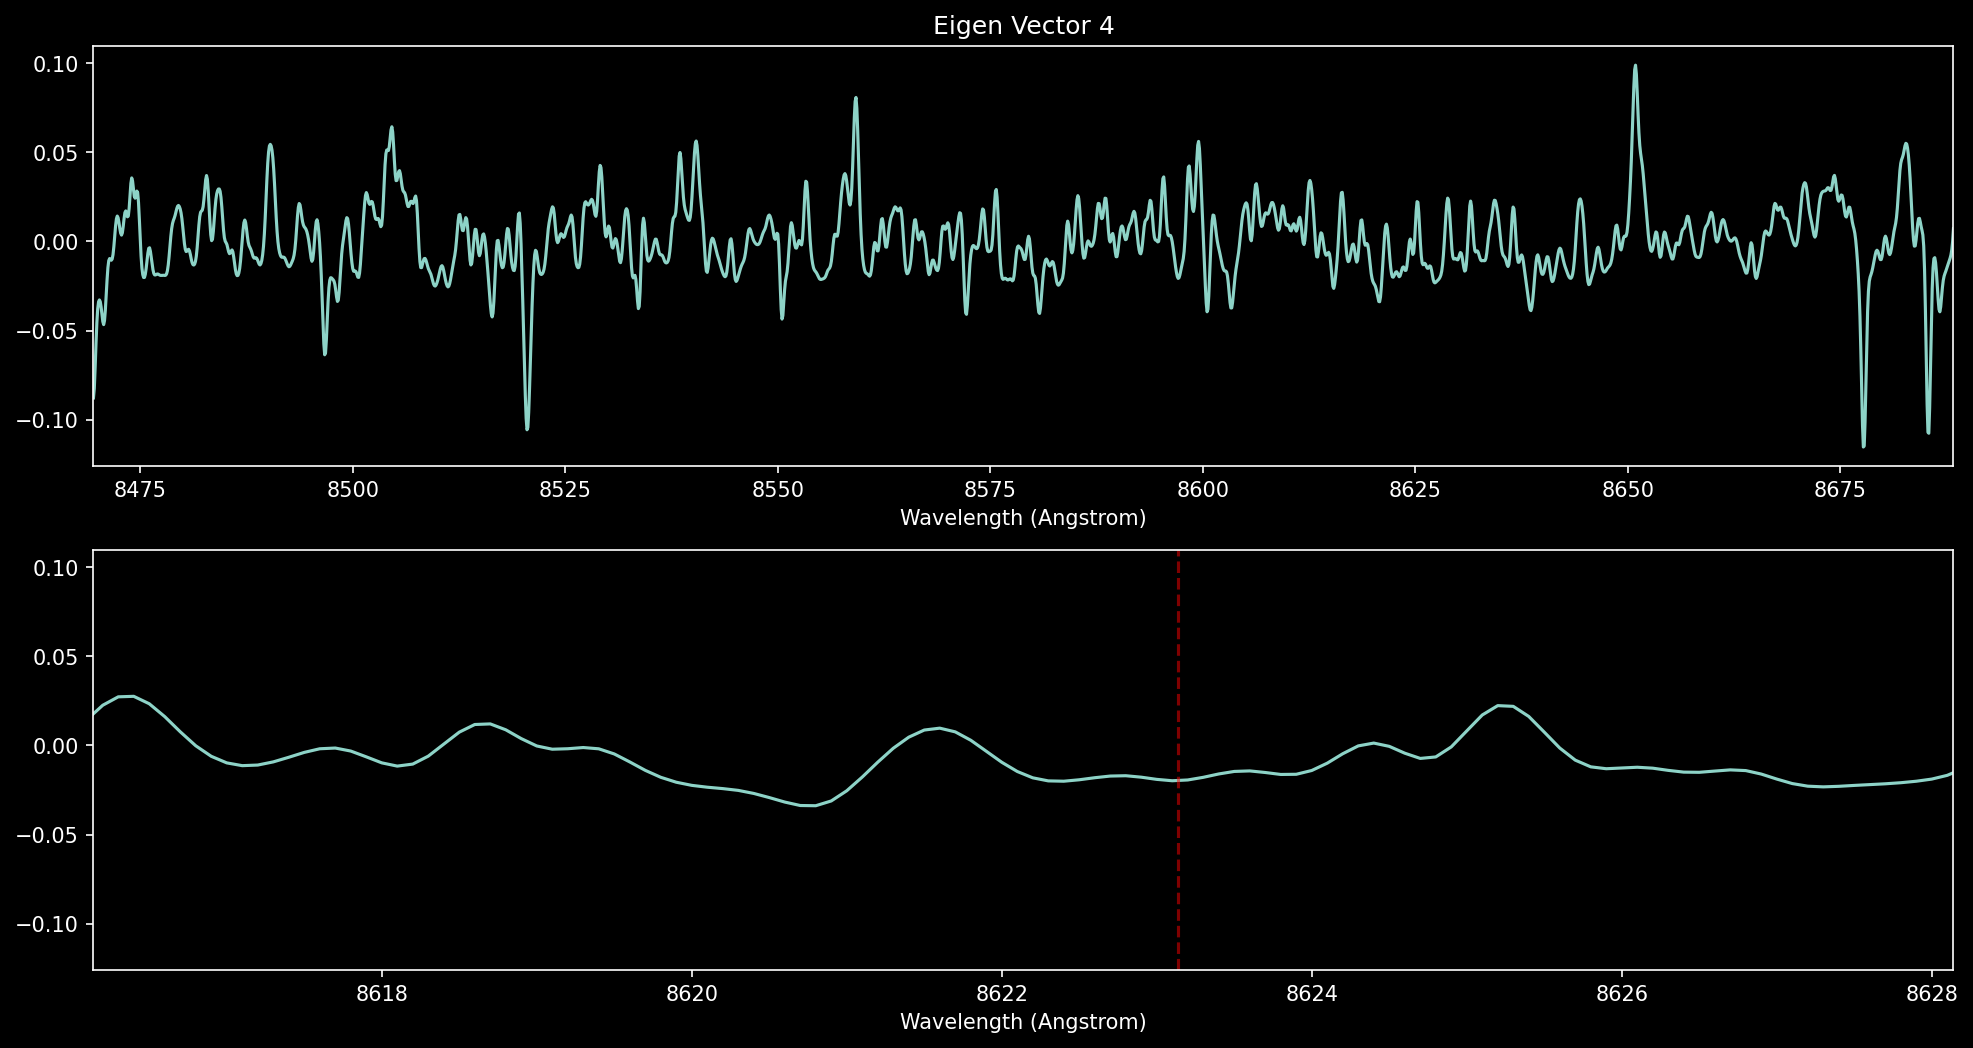

In [94]:
fig = plt.figure(figsize=(16,8),dpi=150)
ax = fig.add_subplot(2,1,1)
ax.plot(wavex[star_msk],diag(Cstar))
ax.set_xlim(minw,maxw)
ax.set_xlabel("Wavelength (Angstrom)")
ax.set_title("Diagonal Stellar Covariance")

ax = fig.add_subplot(2,1,2)
ax.plot(wavex[star_msk],diag(Cstar))
ax.set_xlim(cwave-7,cwave+5)

ax.axvline(cwave,color="red",linestyle="--",alpha=0.5)

ax.set_xlabel("Wavelength (Angstrom)")

for indx = 1:4
    
    fig = plt.figure(figsize=(16,8),dpi=150)
    ax = fig.add_subplot(2,1,1)
    ax.plot(wavex[star_msk],SF.U[:,indx])
    ax.set_xlim(minw,maxw)
    ax.set_xlabel("Wavelength (Angstrom)")
    ax.set_title("Eigen Vector $indx")

    ax = fig.add_subplot(2,1,2)
    ax.plot(wavex[star_msk],SF.U[:,indx])
    ax.set_xlim(cwave-7,cwave+5)

    ax.axvline(cwave,color="red",linestyle="--",alpha=0.5)

    ax.set_xlabel("Wavelength (Angstrom)")
end

In [95]:
nsub = 50
λ, V, info = eigsolve(Symmetric(Cstar),nsub,krylovdim=2*nsub,issymmetric=true,:LR);

In [97]:
fname = "../priors/RVS_stellar_zeroweighted_kry_50_95_const_dusty.h5"
h5write(fname,"Cstar",Cstar)
h5write(fname,"Cstarinv",Cstarinv)
h5write(fname,"Vmat",hcat(V[1:nsub]...)*Diagonal(sqrt.(λ[1:nsub])))
h5write(fname,"λv",λ[1:nsub])
h5write(fname,"λinv",1 ./λ[1:nsub]);
h5write(fname,"msk",convert.(Int,msk_dirt));
h5write(fname,"train_source_id",grvs_id[msk_dirt]); 

# Noise Prior

Inspecting the residual component from a model with only diagonal noise reveals the interpolation kernel used upstream. We will deomonstrate that briefly with the residuals from a star+residuals decomposition that used a diagonal prior for the residual component.

In [98]:
f = h5open("../out/prod_wu_full/scan_μ_cd0.h5");
μ_cd_mat = read(f["μ_cd0"])[:,msk_inter]
close(f)

In [99]:
size(μ_cd_mat)

(2401, 39657)

In [100]:
cov_noise = μ_cd_mat * μ_cd_mat';

In [101]:
renorm = Diagonal(1 ./sqrt.(cov_noise[diagind(cov_noise,0)]))
cov_noise_r = renorm*cov_noise*renorm;

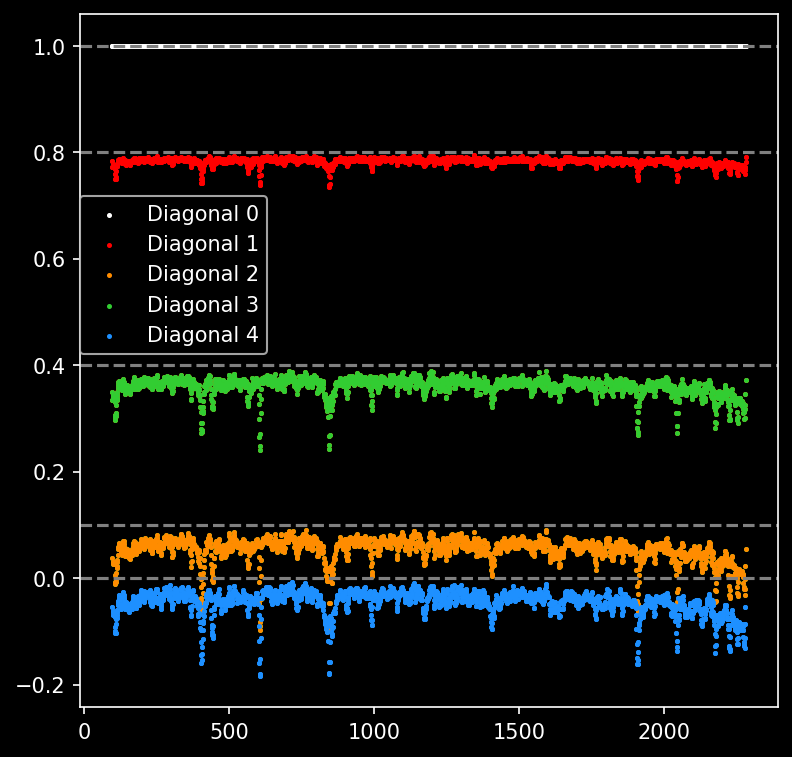

PyObject <matplotlib.lines.Line2D object at 0x1464b5d8cd30>

In [102]:
fig = plt.figure(figsize=(6,6),dpi=150)
ms = 2
ax = fig.add_subplot(1,1,1)
ax.scatter(1:2401,cov_noise_r[diagind(cov_noise_r,0)],color="w",s=ms)
ax.scatter(2:2401,cov_noise_r[diagind(cov_noise_r,1)],color="red",s=ms)
ax.scatter(2:2400,cov_noise_r[diagind(cov_noise_r,2)],color="darkorange",s=ms)
ax.scatter(3:2400,cov_noise_r[diagind(cov_noise_r,3)],color="limegreen",s=ms)
ax.scatter(3:2399,cov_noise_r[diagind(cov_noise_r,4)],color="dodgerblue",s=ms)
ax.legend(["Diagonal 0","Diagonal 1","Diagonal 2","Diagonal 3","Diagonal 4"],loc=(0,0.51))

ax.scatter(2:2401,cov_noise_r[diagind(cov_noise_r,-1)],color="red",s=ms)
ax.scatter(2:2400,cov_noise_r[diagind(cov_noise_r,-2)],color="limegreen",s=ms)
ax.scatter(3:2400,cov_noise_r[diagind(cov_noise_r,-3)],color="darkorange",s=ms)
ax.scatter(3:2399,cov_noise_r[diagind(cov_noise_r,-4)],color="dodgerblue",s=ms)

ax.axhline(1,color="grey",linestyle="--")
ax.axhline(0.8,color="grey",linestyle="--")
ax.axhline(0.4,color="grey",linestyle="--")
ax.axhline(0.1,color="grey",linestyle="--")
ax.axhline(0,color="grey",linestyle="--")

Here we plot the main diagonal and off-diagonals after normalizing for the diagonal variance. Thus, this kernel appears to have approximately the following analytic form.

In [103]:
mixkern = zeros(nfeat,nfeat);
mixkern[diagind(mixkern,0)].= 1
mixkern[diagind(mixkern,1)].=0.8
mixkern[diagind(mixkern,-1)].=0.8

mixkern[diagind(mixkern,2)].=0.4
mixkern[diagind(mixkern,-2)].=0.4

mixkern[diagind(mixkern,3)].=0.1
mixkern[diagind(mixkern,-3)].=0.1;

In [104]:
sum(mixkern)/count(star_msk)

3.5982640475102787

This is the factor we rescale the diagonal covariance by in order to retain a diagonal model of the residuals, but account for the correlations due to the upstream interpolation.

# Dust Prior

In [105]:
function gauss1d(amp,x0,sigma,pixcoord)
    return amp .* exp.(-0.5 .*((pixcoord.-x0)./sigma).^2)./(sqrt(2*pi))
end

function gauss1d_deriv(amp,x0,sigma,pixcoord)
    return - amp .* (pixcoord.-x0) ./(sigma^2) .* exp.(-0.5 .*((pixcoord.-x0)./sigma).^2)./(sqrt(2*pi))
end

gauss1d_deriv (generic function with 1 method)

In [106]:
cwave_cent = 8623.47

xmin0 = 8460
xmax0 = 8700
wavex = xmin0:0.1:xmax0

star_msk, nansum = deserialize("../priors/star_mask.jdat");

wavered = wavex[star_msk];

In [107]:
sigrng = 0.4:0.01:4.0
offrng = 0.05:(-0.01):(-0.04)

Vall = zeros(count(star_msk),2,length(sigrng),length(offrng))

amp = 0.1
damp = 0.01
for (sigindx,sigma) in enumerate(sigrng), (sindx,offset) in enumerate(offrng)
    x0 = cwave_cent+offset
    Vall[:,1,sigindx,sindx] .= gauss1d(amp,x0,sigma,wavered)
    Vall[:,2,sigindx,sindx] .= gauss1d_deriv(damp*amp,x0,sigma,wavered)
end

norm_array = dropdims(sum(Vall.^2,dims=1),dims=1);

covdet = zeros(length(sigrng),length(offrng))
for (sigindx,sigma) in enumerate(sigrng), (sindx,offset) in enumerate(offrng)
    covdet[sigindx,sindx] = logdet(2*pi.*Diagonal(norm_array[:,sigindx,sindx]))
end

This creates the covariance matrix prior for the dust by directly and analytically computing the eigenvectors.

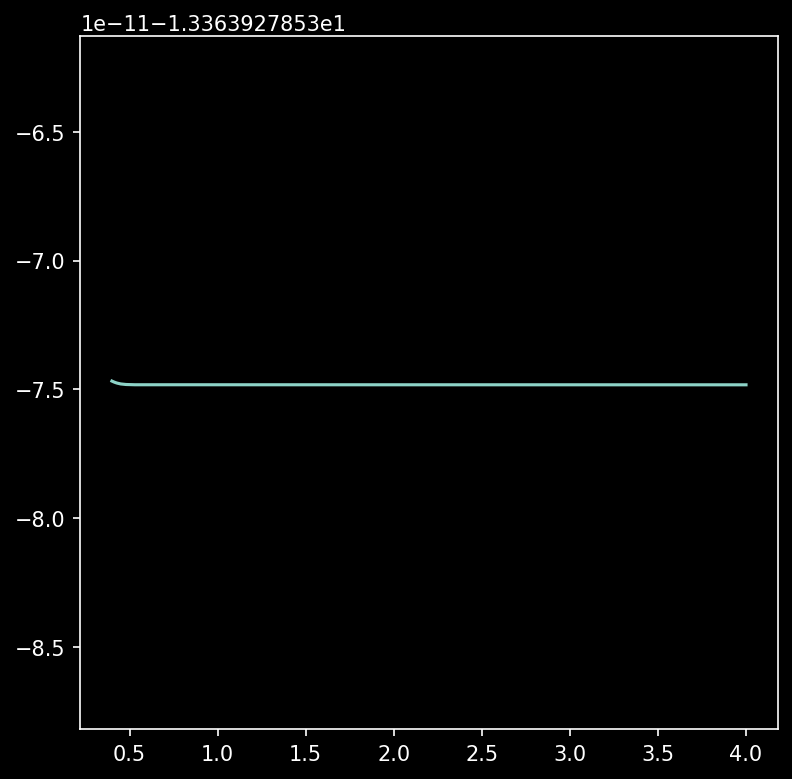

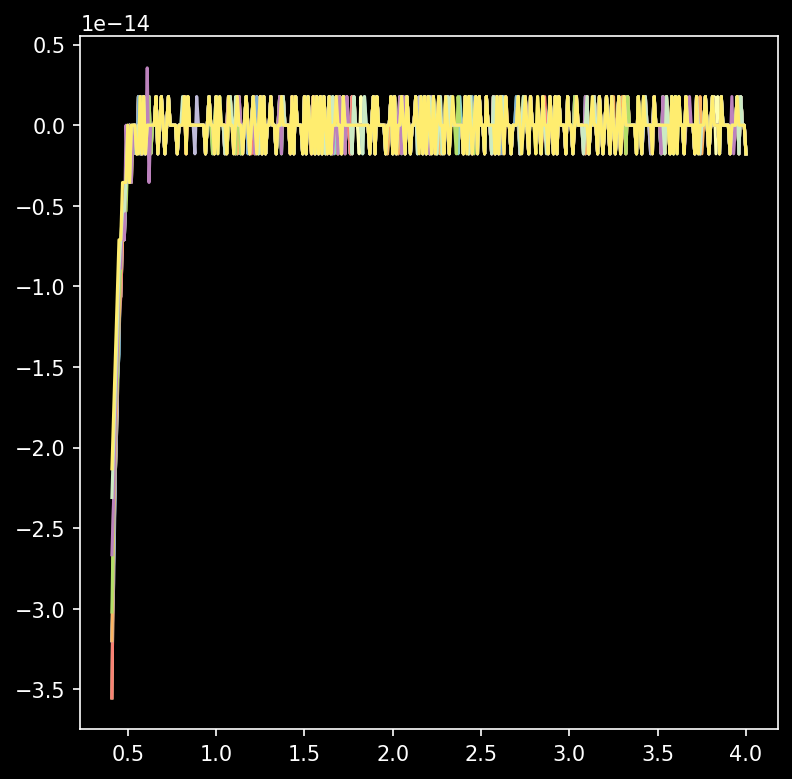

In [108]:
fig = plt.figure(figsize=(6,6),dpi=150)
nbin = 101
ax = fig.add_subplot(1,1,1)
ax.plot(
    sigrng,
    covdet[:,5],
    linestyle="-"
);

fig = plt.figure(figsize=(6,6),dpi=150)
nbin = 101
ax = fig.add_subplot(1,1,1)
ax.plot(
    sigrng[1:end-1].+0.01,
    diff(covdet[:,:],dims=1),
    linestyle="-"
);

This just demonstrates exactly how flat the prior is with respect to sigma. It is at the level of numerical precision.

In [109]:
fname = "../priors/precomp_dust_2_analyticDeriv.h5"
h5write(fname,"Vmat",Vall)
h5write(fname,"covdet",covdet)